### 1.1: Imports and Setup

This section loads the required packages, defines paths, and sets up a flexible data loader for reading NIfTI scans and segmentation masks. This ensures consistency across both EDA and modeling phases.


In [170]:
#!/usr/bin/env python3

# --- Core Libraries ---
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact
import albumentations as A
import warnings
warnings.filterwarnings("ignore")

# --- Plotting ---
%matplotlib inline


### 1.2: Configuration and Scan Loader

The `ImageReader` class handles 3D MRI scan loading and preprocessing in a clean, reusable way. It supports:

- ✅ Loading `.nii` volumes for any modality (`t1`, `t1ce`, `t2`, `flair`)
- ✅ Optional loading of associated segmentation masks (`*_seg.nii`)
- ✅ Resizing and padding using `albumentations` (to consistent `img_size`)
- ✅ Optional normalization of scan voxel intensities to the `[0, 1]` range


This class is designed to keep I/O logic and preprocessing **consistent across patients, phases (EDA vs modeling), and modalities**.

**Key Parameters:**
- `root`: Base folder for the dataset
- `img_size`: Output image shape (used for resizing)
- `normalize`: Whether to scale voxel intensities to `[0, 1]`
- `with_seg`: Whether to load segmentation masks (training data only)

**Returns:**
A dictionary:
- `'scan'`: Normalized, resized 3D scan as `(slices, H, W)`
- `'seg'` *(optional)*: Matching 3D segmentation mask as `(slices, H, W)`


In [171]:
# --- Project Configuration ---
MODALITIES = ['t1', 't1ce', 't2', 'flair']

TRAINING_ROOT = "../data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
VALIDATION_ROOT = "../data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

USE_TRAINING = True  # Set True to use training set (includes segmentation masks)
DATA_ROOT = TRAINING_ROOT if USE_TRAINING else VALIDATION_ROOT
SAMPLE_ID = "BraTS20_Training_001" if USE_TRAINING else "BraTS20_Validation_001"
SCAN_TYPE = 'flair'
SEG = True

In [172]:
# --- ImageReader Class (Reusable Loader) ---
class ImageReader:
    def __init__(self, root: str, img_size: int = 256, normalize: bool = False):
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose([
            A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
            A.Resize(img_size, img_size)
        ])
        self.normalize = normalize
        self.root = root

    def read_file(self, path: str, with_seg: bool = False) -> dict:
        raw_image = nib.load(path).get_fdata()
        scan_type = path.split('_')[-1].split('.')[0]
        processed_frames, masks = [], []

        if with_seg:
            mask_path = path.replace(scan_type, 'seg')
            raw_mask = nib.load(mask_path).get_fdata()
        else:
            raw_mask = None

        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            if with_seg:
                mask = raw_mask[:, :, frame_idx]
                resized = self.resize(image=frame, mask=mask)
                processed_frames.append(resized['image'])
                masks.append(resized['mask'])
            else:
                resized = self.resize(image=frame)
                processed_frames.append(resized['image'])

        scan_data = np.stack(processed_frames, 0)

        if self.normalize and scan_data.max() > 0:
            scan_data = scan_data / scan_data.max()
            scan_data = scan_data.astype(np.float32)

        result = {'scan': scan_data, 'orig_shape': raw_image.shape}
        if with_seg:
            result['seg'] = np.stack(masks, 0)

        return result

    def load_patient_scan(self, patient_id: str, scan_type: str = 'flair', with_seg: bool = False) -> dict:
        scan_path = os.path.join(self.root, patient_id, f"{patient_id}_{scan_type}.nii")
        return self.read_file(scan_path, with_seg=with_seg)




### 1.3: Load & Inspect Scan

We now instantiate the `ImageReader` and load a single patient’s scan. This uses the configuration parameters set above (e.g., `SAMPLE_ID`, `SCAN_TYPE`, and `SEG`).

We load the FLAIR scan for a single patient using our standardized reader.

This step performs the following:
- Reads the specified MRI modality (`flair`, `t1`, etc.)
- Applies resizing and optional normalization
- Optionally includes the segmentation mask if `SEG=True`

In [173]:
# --- Load Scan Using ImageReader ---
reader = ImageReader(root=DATA_ROOT, img_size=128, normalize=True)
scan_dict = reader.load_patient_scan(SAMPLE_ID, scan_type=SCAN_TYPE, with_seg=SEG)
volume = scan_dict['scan']

print(f"Scan shape (slices x H x W): {volume.shape}")
print(f"Voxel intensity range: {volume.min():.2f} to {volume.max():.2f}")

Scan shape (slices x H x W): (155, 128, 128)
Voxel intensity range: 0.00 to 1.00


### 1.4: Thresholding and Subsampling

To reduce rendering overhead and eliminate low-intensity background noise (e.g., air, padding), we threshold and downsample the MRI scan:

- **Thresholding**: Voxels below the threshold (e.g., 0.2) are discarded
- **Subsampling**: We retain every Nth voxel along each axis (default is 2)

This step significantly improves rendering speed in the next step while preserving the brain’s anatomical structure.

We also compute the `(x, y, z)` coordinates and voxel intensities for all retained points — these will be visualized as a 3D scatter cloud.


In [174]:
# --- Preprocessing for 3D Voxel Rendering ---
threshold = 0.2
subsample_rate = 2

binary_mask = volume > threshold
subsample = (slice(None, None, subsample_rate),
             slice(None, None, subsample_rate),
             slice(None, None, subsample_rate))
vol = volume[subsample]
mask = binary_mask[subsample]

x, y, z = np.where(mask)
intensities = vol[x, y, z]

print(f"Voxels retained after thresholding and subsampling: {len(x)}")


Voxels retained after thresholding and subsampling: 45104


### 1.5: 3D Visualization (with Optional Tumor Segmentation)

This section renders a 3D scatter plot of the thresholded MRI scan using Plotly. The anatomical axes are remapped to reflect true orientation, and the aspect ratio is adjusted to prevent vertical distortion.

If segmentation (`SEG = True`) is enabled, we also overlay tumor labels on the same plot using color-coded markers:

- **Label 1 (Red)** → Tumor Core  
- **Label 2 (Blue)** → Edema (swelling)  
- **Label 4 (Green)** → Enhancing Tumor (active regions)

A legend and dynamic title indicate which sample is visualized and whether segmentation data is included.



In [175]:
# --- Base Plot for MRI Volume ---
fig = go.Figure(data=go.Scatter3d(
    x=z,
    y=y,
    z=x,
    mode='markers',
    marker=dict(
        size=1.5,
        color=intensities,
        colorscale='Viridis',
        opacity=0.6
    ),
    name=f'{SCAN_TYPE.upper()} Scan'
))

# --- Conditional Segmentation Overlays ---
if SEG:
    seg = scan_dict['seg'][subsample]  # downsample segmentation to match voxel plot
    label_defs = [
        (1, "Tumor Core", "Reds"),
        (2, "Edema", "Blues"),
        (4, "Enhancing Tumor", "Greens")
    ]

    for label, name, color in label_defs:
        sx, sy, sz = np.where(seg == label)
        if len(sx) == 0:
            continue  # Skip labels not present
        fig.add_trace(go.Scatter3d(
            x=sz, y=sy, z=sx,
            mode='markers',
            marker=dict(
                size=3,
                color=[label] * len(sx),
                colorscale=color,
                opacity=0.6
            ),
            name=name
        ))

# --- Layout & Final Display ---
seg_status = "with SEG" if SEG else "no SEG"

fig.update_layout(
    title=f"3D MRI Scan ({SCAN_TYPE.upper()}) - {SAMPLE_ID} [{seg_status}]",
    scene=dict(
        xaxis_title='Left–Right (Z axis)',
        yaxis_title='Superior–Inferior (Y axis)',
        zaxis_title='Anterior–Posterior (X axis)',
        aspectmode='manual',
        aspectratio=dict(x=1, y=0.7, z=0.8)
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


In [176]:
if SEG:
    mask_sum = scan_dict['seg'].sum()
    print(f"Mask voxel count (non-zero): {int(mask_sum)}")


Mask voxel count (non-zero): 131912


### Final Summary (Markdown Cell for End of Section)

In this section, I built a basic 3D brain visualization pipeline using a FLAIR scan from the BraTS2020 dataset. I loaded and normalized the data, removed low-intensity voxels, and created a sparse 3D visualization using Plotly. This not only helps validate data quality but sets the foundation for deeper analysis and segmentation modeling.
In practice, this step reveals challenges like rendering speed, image noise, and voxel range variability — all of which are essential considerations when building deployable medical AI systems.

# Section 2 EDA

### Part 2.1: Dataset overview

Before doing anything advanced, we do a quick check of the dataset:

- Make sure all patients have all four MRI modalities (T1, T1ce, T2, FLAIR)
- Confirm the scans are the same shape

This helps catch any missing files or issues early.


In [177]:
### Section 2.1: Load Modalities for Single Patient

# Load each modality (T1, T1ce, T2, FLAIR) using the unified ImageReader
volumes = {
    mod: reader.load_patient_scan(SAMPLE_ID, scan_type=mod)['scan']
    for mod in MODALITIES
}

print(f"Loaded modalities: {list(volumes.keys())}")
for mod, vol in volumes.items():
    print(f"{mod.upper()} shape: {vol.shape}, range: {vol.min():.2f} – {vol.max():.2f}")


Loaded modalities: ['t1', 't1ce', 't2', 'flair']
T1 shape: (155, 128, 128), range: 0.00 – 1.00
T1CE shape: (155, 128, 128), range: 0.00 – 1.00
T2 shape: (155, 128, 128), range: 0.00 – 1.00
FLAIR shape: (155, 128, 128), range: 0.00 – 1.00


In [178]:
shapes = [vol.shape for vol in volumes.values()]
if len(set(shapes)) == 1:
    print("✅ All modalities have consistent shape:", shapes[0])
else:
    print("⚠️ Modalities have inconsistent shapes:", shapes)


✅ All modalities have consistent shape: (155, 128, 128)


### Section 2.2: Modality Comparison for a Single Patient

We take one subject and look at the voxel intensity distributions for each of the four scan types.

This gives us a feel for how different modalities behave, and helps plan any normalization or preprocessing steps.


In [179]:
### Section 2.2: Define Function to Plot Central Axial/Coronal/Sagittal Slices

def show_slices(volume, title):
    """
    Displays three orthogonal views (axial, coronal, sagittal) from a 3D MRI volume.
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Axial = top-down view
    axes[0].imshow(np.rot90(volume[:, :, volume.shape[2] // 2]), cmap='gray')
    axes[0].set_title('Axial')

    # Coronal = front-facing view
    axes[1].imshow(np.rot90(volume[:, volume.shape[1] // 2, :]), cmap='gray')
    axes[1].set_title('Coronal')

    # Sagittal = side view
    axes[2].imshow(np.rot90(volume[volume.shape[0] // 2, :, :]), cmap='gray')
    axes[2].set_title('Sagittal')

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


### Section 2.3: Visualising Central Slices (Axial, Coronal, Sagittal)

To get a better visual sense of each scan, we look at three views:

- Axial (top-down)
- Coronal (front)
- Sagittal (side)

This shows us the scan orientation and how each modality captures structure.


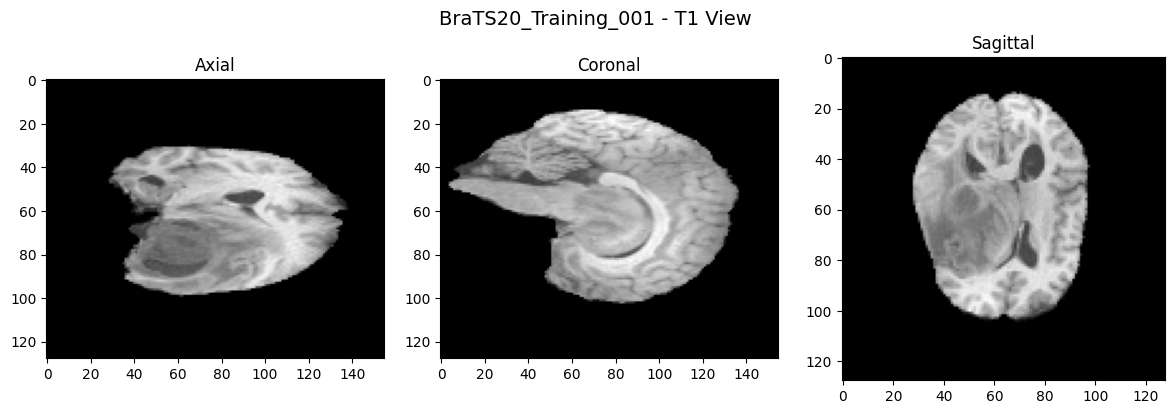

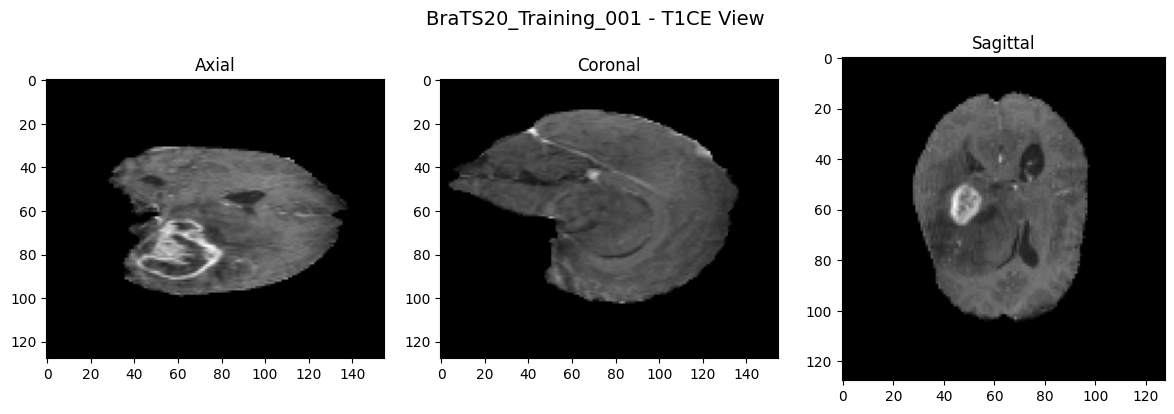

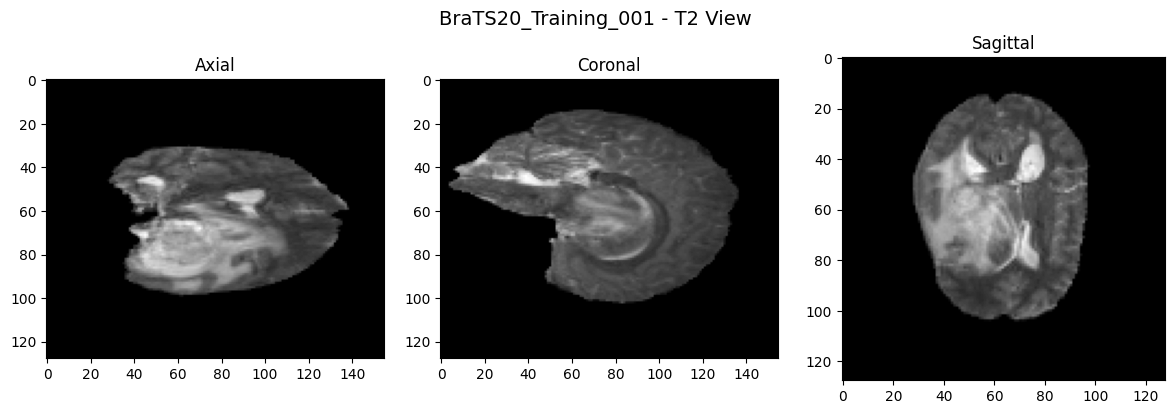

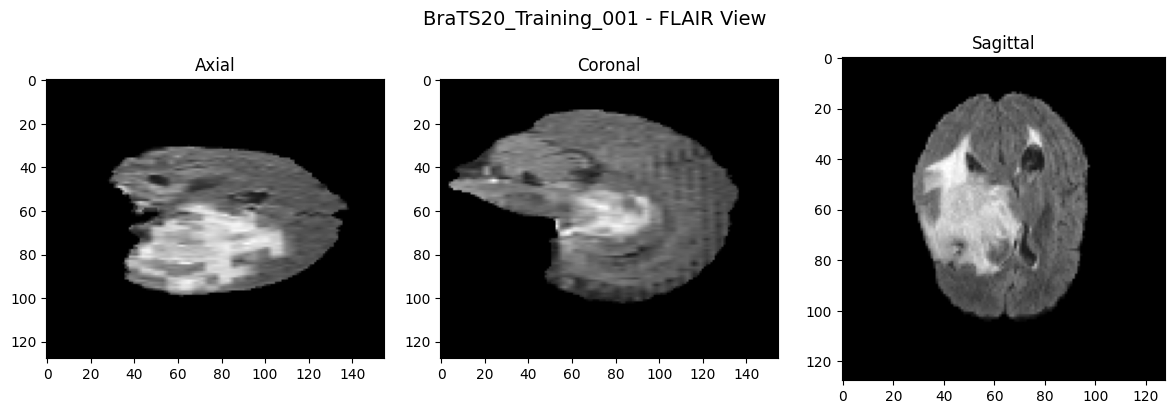

In [180]:
### Section 2.3: Display Central Slices for All Modalities

for mod in MODALITIES:
    show_slices(volumes[mod], f"{SAMPLE_ID} - {mod.upper()} View")


### Section 2.4: Voxel Intensity Histograms

To further inspect each modality, we plot intensity distributions (excluding background values). This helps identify:
- Contrast levels across modalities
- Any outliers or inconsistencies
- Normalization requirements


T1 — Mean: 0.58, Std: 0.16, Min: 0.00, Max: 1.00
T1CE — Mean: 0.22, Std: 0.06, Min: 0.00, Max: 1.00
T2 — Mean: 0.30, Std: 0.13, Min: 0.00, Max: 1.00
FLAIR — Mean: 0.34, Std: 0.14, Min: 0.00, Max: 1.00


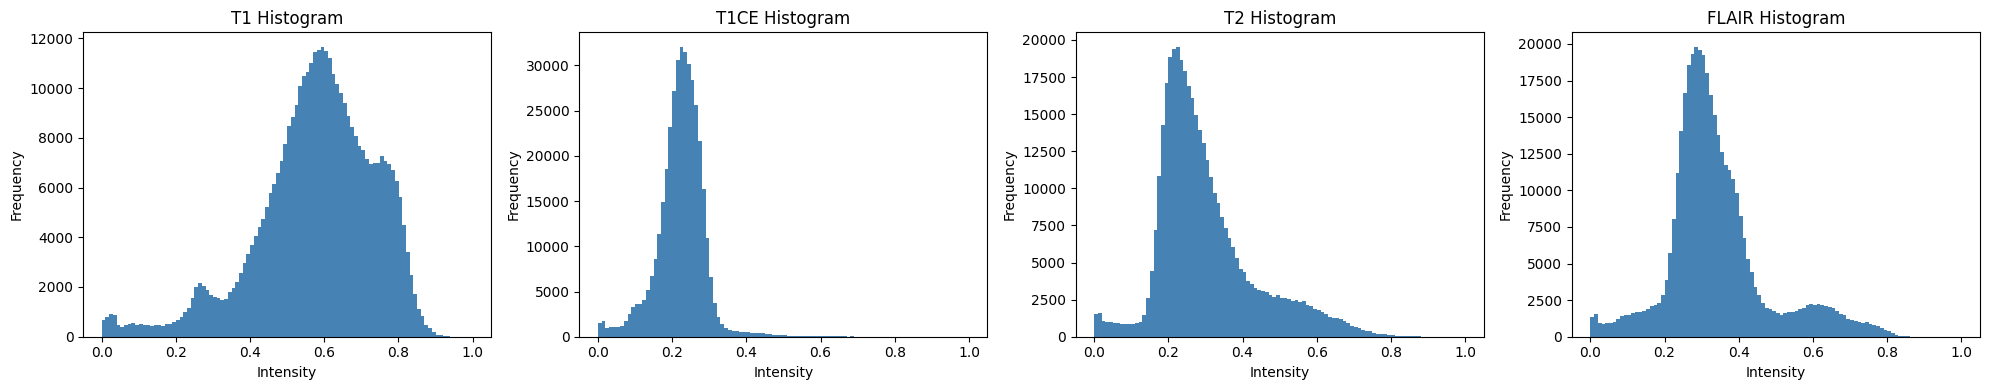

In [181]:
### Section 2.4: Intensity Distribution Histograms for Each Modality

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for i, mod in enumerate(MODALITIES):
    data = volumes[mod]
    non_zero = data[data > 0]  # ignore background

    axes[i].hist(non_zero.ravel(), bins=100, color='steelblue')
    axes[i].set_title(f"{mod.upper()} Histogram")
    axes[i].set_xlabel("Intensity")
    axes[i].set_ylabel("Frequency")

    print(f"{mod.upper()} — Mean: {np.mean(non_zero):.2f}, Std: {np.std(non_zero):.2f}, "
          f"Min: {np.min(non_zero):.2f}, Max: {np.max(non_zero):.2f}")

plt.tight_layout()
plt.show()


In [182]:
full_range = (np.min([v.min() for v in volumes.values()]),
              np.max([v.max() for v in volumes.values()]))
print(f"Global voxel intensity range across all modalities: {full_range}")


Global voxel intensity range across all modalities: (np.float32(0.0), np.float32(1.0))


### Section 2.5: Summary & Interpretation

- **T1** shows brain structure with a tight, consistent range  
- **T1ce** has higher intensity regions from contrast enhancement (useful for tumors)  
- **T2** highlights fluid-filled areas like ventricles or swelling  
- **FLAIR** filters out fluid and is great for spotting lesions

These differences are important — we’ll normalize each modality separately and keep all four as input channels.

### Section 3 Visual Comparrison of 3D scans across Modalaties

### Section 3.1: Modeling Objective

Now that our dataset is normalized and verified, we begin building a supervised segmentation model using the BraTS2020 training data.

**Objective**:  
Train a deep learning model (e.g., 3D U-Net) to predict brain tumor regions (labelled 1, 2, 4) from multi-modal 3D MRI scans.

**Input (X)**:  
A 3D volume stack with 4 channels: `[T1, T1ce, T2, FLAIR]`

**Target (y)**:  
The corresponding segmentation mask volume:  
Shape = `(slices, height, width)` with voxel labels:  
- `0 = background`
- `1 = Tumor Core`
- `2 = Edema`
- `4 = Enhancing Tumor`
